In [1]:
import sys
import gc
import os
#base_dir = "drive/My Drive/jp_en_translation/".replace("/",os.sep)
base_dir = "../"
emb_dir = "drive/My Drive/util_data/".replace("/",os.sep)
sys.path.append("/Users/ueki/Desktop/work/jp_en_translation")
sys.path.append("/Users/ueki/Desktop/JP_EN_Transalation")
sys.path.append(base_dir)
sys.path.append("drive/My Drive/jp_en_translation".replace("/",os.sep))

In [2]:
from models.S2S_attention import Seq2Seq
from utils.LangEn import LangEn
from utils.LangJa import LangJa
from utils.build_emb import build_en_emb,build_jp_emb
from utils.preprocess import loadLangs
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
import torch

Using TensorFlow backend.


In [3]:
config={
    "corpus_file":base_dir+"data/jpn.txt",
    "en_col":"description_en",
    "jp_col":"description_jp",
    "mask_token":0,
    "SOS_token":1,
    "EOS_token":2,
    "UNK_token":3,
    "max_features":8000,
    "MAX_LENGTH":20,
    "train_size":15000,
    "val_size":300,
    "batch_size":128,
    "epochs":1,
    "maxlen_enc":20,
    "maxlen_dec":20,
    "n_hidden":500,
    "input_dim":5000,
    "jp_voc":8000,
    "en_voc":5000,
    "output_dim":8000,
    "emb_dim":300,
    "use_enc_emb":False,
    "use_dec_emb":False,
    "validation_split":0.01,
    "trained_param_dir":base_dir+"trained_models/1_lstm_ja_en_01.hdf5",
    "translate_length":20,
    "en_W2V_FILE" : emb_dir+"GoogleNews-vectors-negative300.bin.gz",
    "jp_W2V_FILE":emb_dir+"ja_data/ja.bin",
    "src":"en",
    "trg":"jp",
    "learning_rate":0.001,
}

# train

In [4]:
data=loadLangs(config)

reading lines


In [5]:
val_data = data[config["train_size"]:config["train_size"]+config["val_size"]]
data = data[:config["train_size"]]

In [6]:
EN_lang = LangEn(config)
JP_lang = LangJa(config)

W0809 14:38:54.023596 4474623424 toolwrapper.py:77] stdbuf was not found; communication with perl may hang due to stdio buffering.


In [7]:
for s in data[config["en_col"]]:
    EN_lang.addSentence(s)

In [8]:
for s in data[config["jp_col"]]:
    JP_lang.addSentence(s)

## input の加工

In [9]:
if config["src"]=="jp":
    src_col=config["jp_col"]
    trg_col=config["en_col"]
    Langs={"src":JP_lang,"trg":EN_lang}
else:
    src_col=config["en_col"]
    trg_col=config["jp_col"]
    Langs={"trg":JP_lang,"src":EN_lang}

In [10]:
input_en = data[src_col]

In [11]:
input_source_lang=data[src_col].apply(lambda x:Langs["src"].word2id(x))
input_target_lang=data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [12]:
val_source = val_data[src_col].apply(lambda x:Langs["src"].word2id(x))
val_target = val_data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [13]:
input_source_padded=sequence.pad_sequences(input_source_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
input_target_padded=sequence.pad_sequences(input_target_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [14]:
val_source_padded=sequence.pad_sequences(val_source,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
val_target_padded=sequence.pad_sequences(val_target,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## create embedding

In [16]:
#en_emb = build_en_emb(config,EN_lang.word2index)

In [17]:
#ja_emb = build_jp_emb(config,JP_lang.word2index)

In [18]:
#if config["src"]=="en":
 #   emb={"src_emb":en_emb,"trg_emb":ja_emb}
#else:
 #   emb={"src_emb":ja_emb,"trg_emb":en_emb}

In [19]:
#print("enc->",emb["trg_emb"].shape)
#print("dec->",emb["src_emb"].shape)

In [20]:
#trainer = Seq2Seq(config,enc_emb=emb["src_emb"],dec_emb=emb["trg_emb"])
trainer = Seq2Seq(config)

In [21]:
trainer.trainIters(input_source_padded,input_target_padded,val_source_padded,val_target_padded)

train_size:15000 - val_size:300


KeyboardInterrupt: 

# test

In [ ]:
ret1 = trainer.translateIter(val_source_padded[:5])
for src,pred,target in zip(val_data[src_col],ret1,val_data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

In [ ]:
trainer.decoder.get_attn_weight()

In [23]:
ret2 = trainer.translateIter(input_source_padded[:20])
for src,pred,target in zip(data[src_col],ret2,data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

input_-> torch.Size([20, 20])
src-> its tom.

pred-> 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上 路上
ans-> トム だ 。
------------------
src-> id like to introduce you to some of my friends.

pred-> 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ 南アフリカ
ans-> あなた を 私 の 友達 に 紹介 し たい の です が 。
------------------
src-> please be careful.

pred-> 南アフリカ 南アフリカ 路上 路上 路上 路上 路上 路上 路上 南アフリカ 南アフリカ 南アフリカ 南アフリカ 路上 路上 路上 路上 路上 路上 南アフリカ
ans-> 気 を つけ て ください 。
------------------
src-> he knows no english not to mention german.

pred-> 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約 公約
ans-> 彼 は ドイツ 語 は 言うまでもなく 、 英語 も 知ら ない 。
------------------
src-> i explained the rules to her.

pred-> 発見 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み 老け込み
ans-> 私 は 彼女 に 規則 を 説明 し た 。
------------------
src-> the titanic sunk on its maiden voyage.

pred-> とい とい とい とい とい とい とい とい とい とい とい とい とい とい

In [ ]:
## attention visualize

input_-> torch.Size([5, 20])
input_-> torch.Size([5, 20])


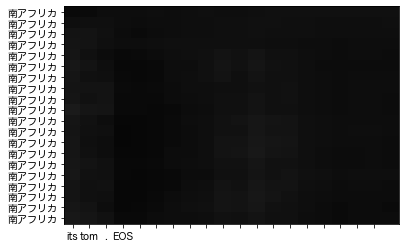

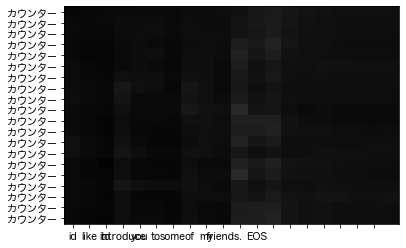

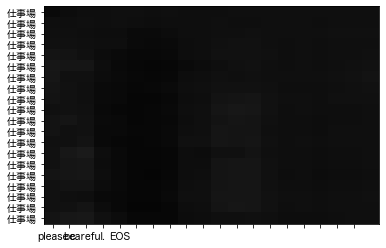

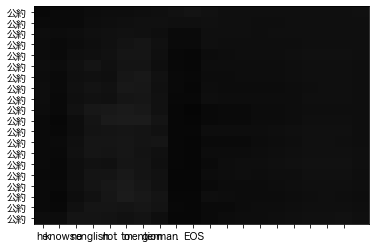

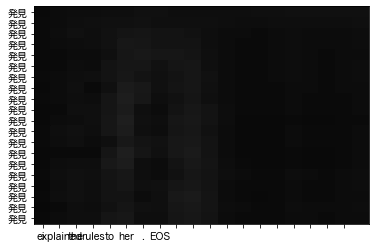

In [22]:
N=5
src = input_source_padded[:N]
trg = input_target_padded[:N]
s_s=[]
s_t=[]
for s in src:
    s_s.append(Langs["src"].id2word(s))
trainer.eval_attn(src,s_s,Langs["trg"].id2word)

In [ ]:
trainer.eval_attn(input_source_padded[:5],input_target_padded[:5])